# Loading example of all the data in a folder

# This functionality has been implemented in windsat_datacube function


In [1]:
import xarray as xr
from functools import partial
import os
import re
from datetime import date

# Path to the folder with the daily data:
folder_path = r"../data/raw/daily_Windsat"

In [2]:
# List all the file names in the folder, save the date and append it to a list:
day_numbers = []  # Day number of 2017
# Regex to extract date
ymd_regex = r"_(\d{4})_(\d{2})_(\d{2})"

for file in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, file)):

        year, month, day = [int(number) for number in re.findall(ymd_regex, file)[0]]
        day_numbers.append(date(year, month, day).timetuple().tm_yday)

In [3]:
def select_datavars(dataset: xr.Dataset) -> xr.Dataset:
    """
    Select only relevant variables (for Brightness temperature)
    """

    selected_dvars = [
        "longitude",
        "latitude",
        "node",  # node of swath, ascending vs descending
        # "look", # look direction, we will select only look = 0 (forward)
        "frequency_vpol",  # center frequency of V-pol channel in each band
        "frequency_hpol",  # center frequency of H-pol channel in each band
        "eia_nominal",  # nominal Earth indidence angle of each band
        "time",  # Time of observation (lat, lon) seconds since 01 JAN 2000 00Z
        "eaa",  # boresight Earth azimuth angle. range: [0o, 360o].
        "eia",  #  boresight Earth incidence angle. range: [0o, 90o]
        "tbtoa",  # Brightness temperature
        "quality_flag",  # 32-bit quality control flag
        # "sss_HYCOM", # HYCOM sea surface salinity
        # "surtep_REY", # NOAA (Reynolds) V2 OI sea surface temperature
        # # Land fractions
        # "fland_06", # for 6GHz
        # "fland_10", # For 10 GHz
        # # Windsat V8 products
        # "surtep_WSAT", # skin temperature
        # "colvap_WSAT", # atmosphere_mass_content_of_water_vapor
        # "colcld_WSAT", # atmosphere_mass_content_of_cloud_liquid_water
        # "winspd_WSAT", # sea surface wind speed
        # "rain_WSAT", # surface rain rate
        # # Cross-Calibrated Multi-Platform
        # "winspd_CCMP", # Wind speed
        # "windir_CCMP", # Cross-Calibrated Multi-Platform Wind direction
        # # ERA 5 products
        # "surtep_ERA5", # skin temperature
        # "airtep_ERA5", # Air temperature at 2m above surface
        # "colvap_ERA5", # Columnar liquid cloud water
        # "colcld_ERA5", # atmosphere_mass_content_of_cloud_liquid_water
        # "winspd_ERA5", # 10-m NS wind speed
        # "windir_ERA5", # Wind direction
        # "surtep_CMC", # CMC Sea surface temperature
        # "rain_IMERG", # IMERG V6 surface rain rate
        # # RSS 2022 absorption model
        # "tran", # Total atmospheric transmittance computed from ERA atmospheric profiles and WSAT columnar vapor and cloud water
        # "tbdw", # Atmospheric downwelling brightness temperature computed from ERA atmospheric profiles and WSAT columnar vapor and cloud water
    ]

    return dataset[selected_dvars]


def select_dims(dataset: xr.Dataset) -> xr.Dataset:
    """
    Remove unused frequencies and polarizations

    Frequencies:
    0 -- 6.8 GHz
    1 -- 10.7 GHz
    2 -- 18.7 GHz (Ku)
    3 -- 23.8 GHz
    4 -- 37.0 GHz (Ka)

    Polarizations:
    0 -- V
    1 -- H
    (except for 6.8 and 23.8 GHz):
    2 -- P (+45º)
    3 -- M (-45º)
    4 -- L (Circular Left)
    5 -- R (Circular Right)
    """

    # Select dimensions
    dataset = dataset.sel(
        indexers={
            "polarization": [0, 1],  # [ V, H ]
            "frequency_band": [2, 4],  # [ 18.7 GHz (Ku) , 37.0 GHz (Ka) ]
            "look_direction": 0,  # Forward
        }
    )
    return dataset


def transform_dataset(dataset: xr.Dataset) -> xr.Dataset:
    """
    Other transformations
    """
    # Roll lattitude grid so we have -180, 180 range
    dataset = dataset.roll(shifts={"longitude_grid": 4 * 180})

    # Extract latitude and longitude grid dimensions
    dataset = dataset.assign_coords(lat=dataset.latitude, lon=dataset.longitude)

    return dataset


def preporcess_dataset(dataset: xr.Dataset) -> xr.Dataset:
    """Wrapper"""
    dataset = select_datavars(dataset)
    dataset = select_dims(dataset)
    dataset = transform_dataset(dataset)
    return dataset


_preprocess_dataset = partial(preporcess_dataset)

In [4]:
# Vitrtually open the combined dataset for all days
ds = xr.open_mfdataset(
    paths="..\\data\\raw\\daily_windsat\\*.nc",
    preprocess=_preprocess_dataset,
    decode_times=False,
    concat_dim="day_number",
    combine="nested",
)

# Add a day_number coordinate
ds["day_number"] = day_numbers
ds["day_number"].attrs = {"Description": "Int, day of the year 2017"}
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 32, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 128B 1 2 3 4 5 6 7 ... 27 28 29 30 31 32
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables:
    longitude       (day_number, longitude_grid) float32 184kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 92kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time            (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float64 1GB dask.array<chunksize=(1, 1, 240, 480, 1), meta=np.ndarray>
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 531MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 531MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 1GB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 265MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

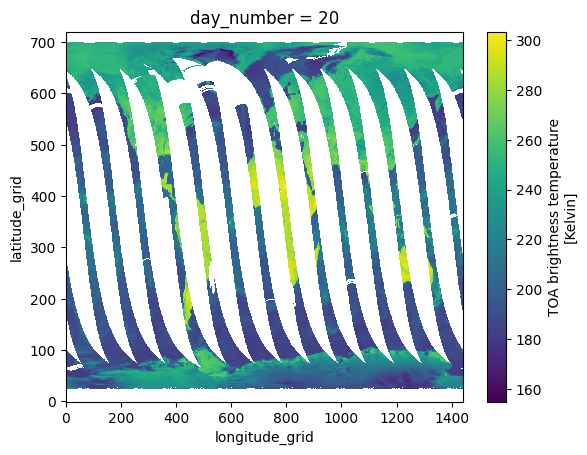

In [5]:
# Data access example, recover and plot a map selecting the frequency, day and other dimensions:
ds.sel(day_number=20, swath_sector=0, frequency_band=0, polarization=0).tbtoa.plot()

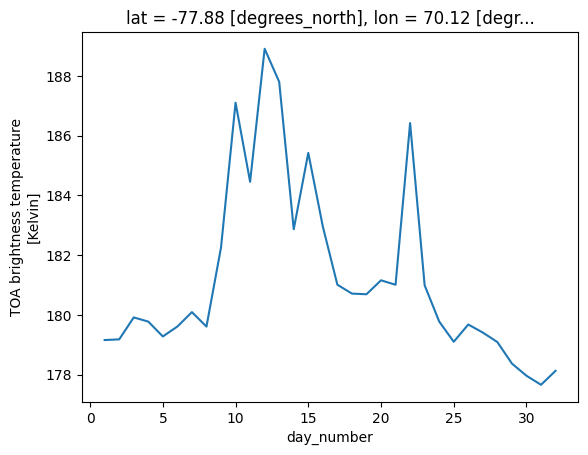

In [22]:
# Select the lattitude and longitude of a particular point and plot its evolution over time:
ds.sel(
    swath_sector=0,
    frequency_band=1,
    polarization=1,
    latitude_grid=12 * 4,
    longitude_grid=250 * 4,
).tbtoa.plot()

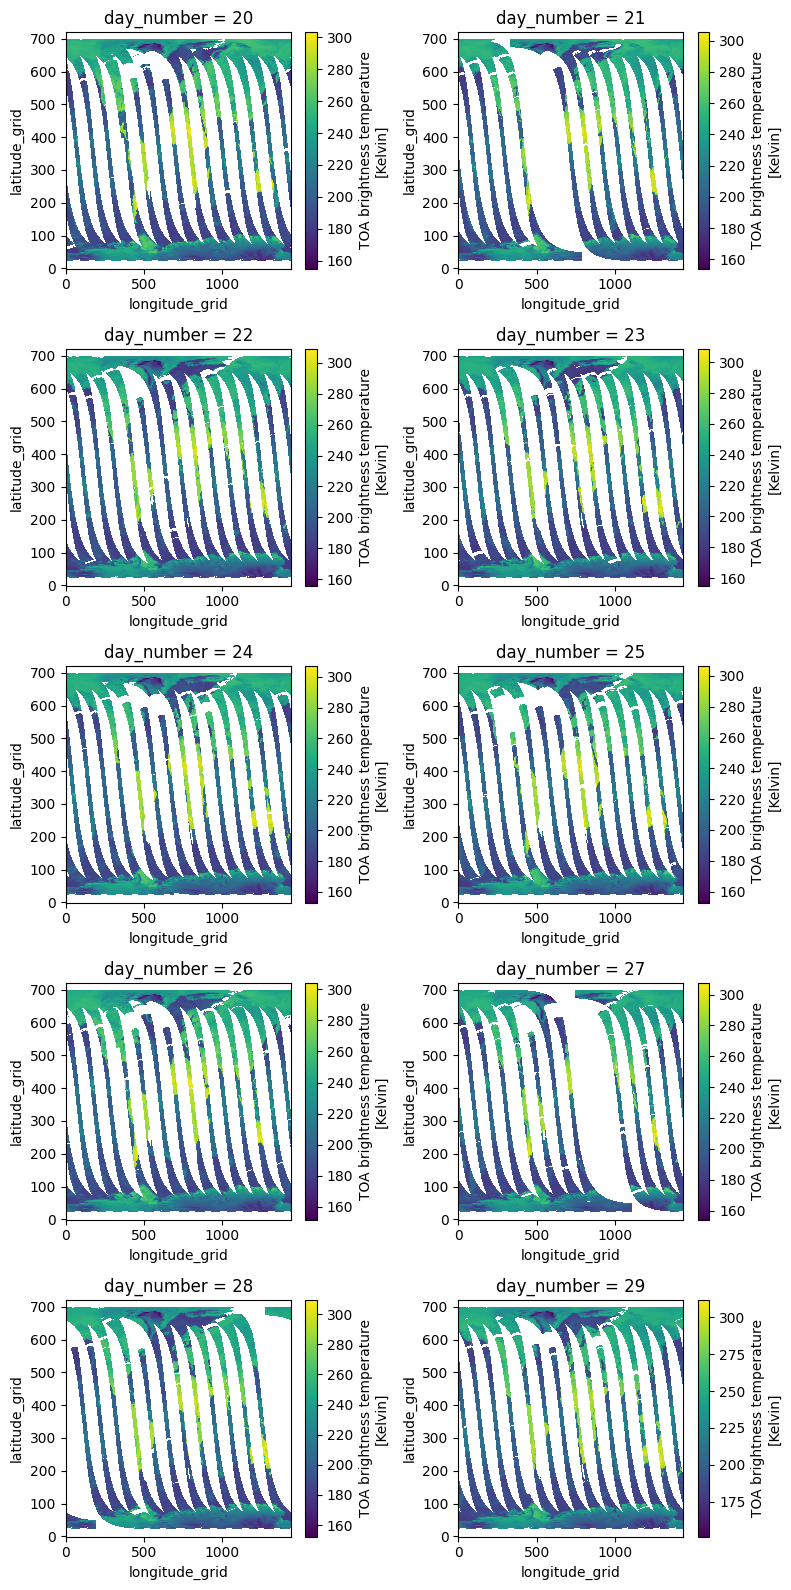

In [23]:
# Plot consecutive days using matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(8, 16))

day = 20
for i in range(0, 5):
    for j in range(0, 2):
        ds.sel(day_number=day, swath_sector=0, frequency_band=0, polarization=0)[
            "tbtoa"
        ].plot(ax=axs[i, j], cmap="viridis")
        day += 1

fig.tight_layout()

In [17]:
# Get a time series from coordinates:
timeseries = ds.sel(
    swath_sector=0,
    frequency_band=1,
    polarization=1,
    latitude_grid=12 * 4,
    longitude_grid=250 * 4,
)["tbtoa"].values
timeseries

array([179.155  , 179.17749, 179.9125 , 179.77249, 179.275  , 179.6075 ,
       180.09   , 179.605  , 182.2525 , 187.1    , 184.4525 , 188.905  ,
       187.7975 , 182.86499, 185.42   , 182.955  , 181.00749, 180.70999,
       180.6875 , 181.155  , 181.005  , 186.4175 , 180.98749, 179.775  ,
       179.0975 , 179.67499, 179.405  , 179.0875 , 178.3675 , 177.95999,
       177.6575 , 178.125  ], dtype=float32)

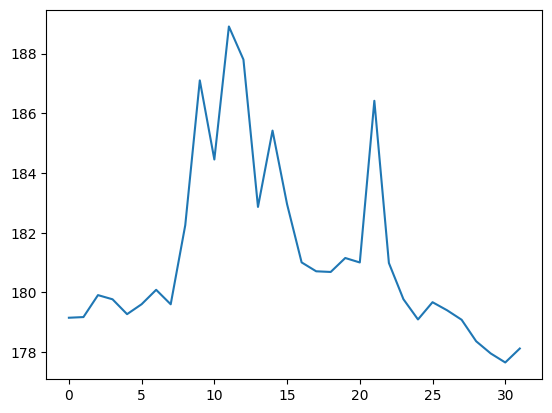

In [22]:
# Create a pandas series from the values:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(pd.Series(timeseries))

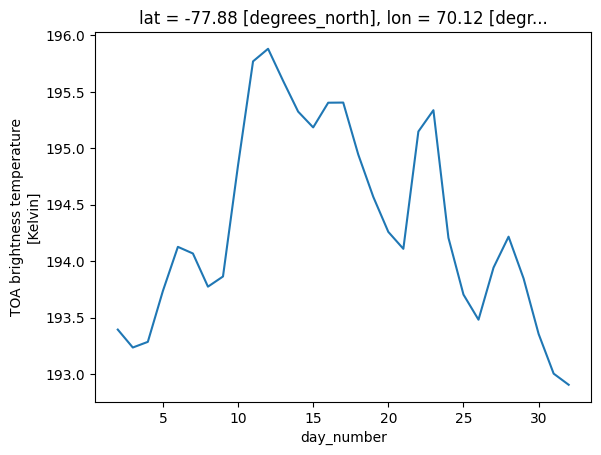

In [43]:
# Get the rolling average of the tbtoa
tbtoa = ds["tbtoa"]

tbtoa.rolling(day_number=2).mean().sel(
    latitude_grid=12 * 4,
    longitude_grid=250 * 4,
    polarization=0,
    frequency_band=0,
    swath_sector=0,
).plot()

In [44]:
ds["tbtoa"]

<xarray.DataArray 'tbtoa' (day_number: 32, polarization: 2, frequency_band: 2,
                           latitude_grid: 720, longitude_grid: 1440,
                           swath_sector: 2)> Size: 1GB
dask.array<concatenate, shape=(32, 2, 2, 720, 1440, 2), dtype=float32, chunksize=(1, 1, 1, 240, 480, 1), chunktype=numpy.ndarray>
Coordinates:
    lat         (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon         (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number  (day_number) int32 128B 1 2 3 4 5 6 7 8 ... 26 27 28 29 30 31 32
Dimensions without coordinates: polarization, frequency_band, latitude_grid,
                                longitude_grid, swath_sector
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement